Подключение зависимостей

In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

2024-05-31 03:03:48.381733: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 03:03:48.524364: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 03:03:49.444733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 03:03:51.486430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Подготовка данных из датасета

In [3]:
datasetFile = pd.read_csv('heart_attack_prediction.csv')
datasetFile = datasetFile.iloc[:, 2:]
datasetFile = datasetFile.sample(frac=1, random_state=42)

parameters = datasetFile.iloc[:, :9].values
all_parameters = datasetFile.iloc[:, :10].values
risk = datasetFile.iloc[:, -1].values

parameters[:, 1] = np.where(parameters[:, 1] == 'Male', 0, 1)
all_parameters[:, 1] = np.where(all_parameters[:, 1] == 'Male', 0, 1)

Разбиение данных на обучающую и тестирующую выборки

In [4]:
parameters_train, parameters_test, risk_train, risk_test = train_test_split(parameters, risk, test_size=0.7)

Скейлинг данных

In [5]:
scaler = preprocessing.StandardScaler().fit(parameters_train)
parameters_train = scaler.transform(parameters_train)

Feature Importance: отбор наиболее значимых параметров

In [6]:
rf = RandomForestClassifier(random_state=42)
rf.fit(parameters_train, risk_train.ravel())

selector = SelectFromModel(rf, prefit=True)
parameters_train_selected = selector.transform(parameters_train)
parameters_test_selected = selector.transform(parameters_test)

Создание модели

In [7]:
model = Sequential()
model.add(Dense(150, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.F1Score(threshold=0.5)])

Обучение

In [8]:
target_train = np.expand_dims(risk_train, axis=-1)
target_test = np.expand_dims(risk_test, axis=-1)
history = model.fit(parameters_train_selected, target_train, epochs=1500, batch_size=32, verbose=1)

Epoch 1/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - f1_score: 0.1118 - loss: 0.6688
Epoch 2/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6529
Epoch 3/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6517
Epoch 4/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6567
Epoch 5/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6551
Epoch 6/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6448
Epoch 7/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6526
Epoch 8/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.0000e+00 - loss: 0.6551
Epoch 9/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.0000e+00 - loss: 0.6538
Epoch 10/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.0000e+00 - loss: 0.6521
Epoch 11/1500
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.0000e+00 - loss: 0.6410
Epoch 12/150

Результат

In [16]:
parameters_test_selected = parameters_test_selected.astype('float32')
prediction = model.predict(parameters_test_selected)
prediction_bin = (prediction > 0.5).astype(int)
f1_score = f1_score(risk_test, prediction_bin, average='micro')
print(f1_score)

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
0.7504726976365118


Построение графиков

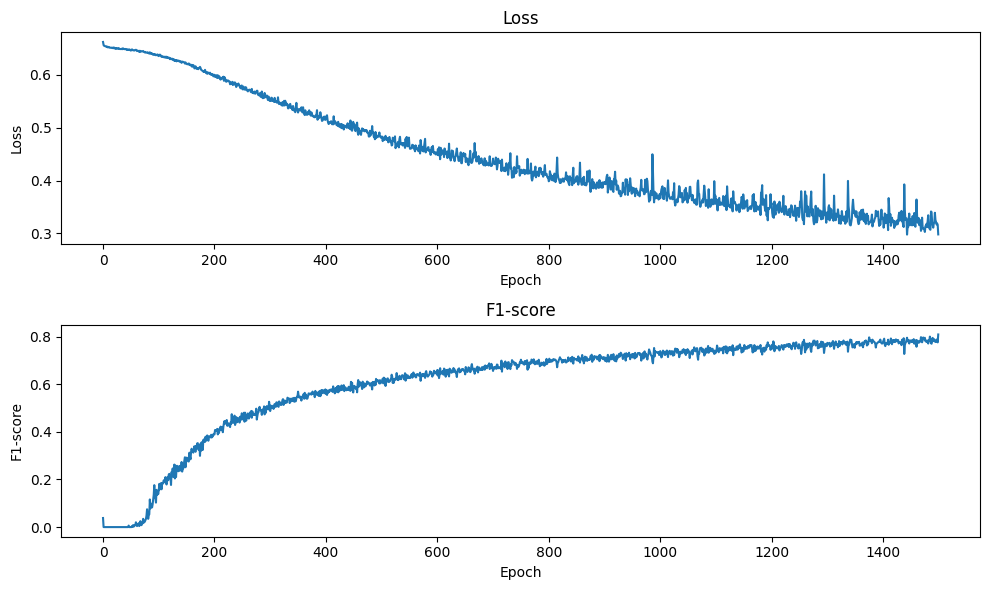

In [10]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['f1_score'])
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()